In [27]:
import pandas as pd
import numpy as np
import math
import random
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
df = pd.read_csv('data/RFM.csv')
# needed columns for the model input
continuous_cols = ['frequency', 'recency', 'T']
categorical_cols = ['Country']

## 1. Prepare Data

In [25]:
# standardisation
x_1 = preprocessing.scale(df[continuous_cols]) # x_1 is an Array 
x_1

array([[-0.30780845,  0.98874414,  0.81299415],
       [-0.30780845,  0.98874414,  0.81299415],
       [-0.30780845,  0.98874414,  0.81299415],
       ...,
       [-0.46224674, -0.64133065, -0.75162267],
       [-0.46224674, -0.64133065, -0.75162267],
       [-0.46224674, -0.64133065, -0.75162267]])

In [19]:
model_input = pd.concat([pd.DataFrame(x_1, columns=continuous_cols), df[categorical_cols]], axis=1)
model_input.head()

,frequency,recency,T,Country
0,-0.307808,0.988744,0.812994,Iceland
1,-0.307808,0.988744,0.812994,Iceland
2,-0.307808,0.988744,0.812994,Iceland
3,-0.307808,0.988744,0.812994,Iceland
4,-0.307808,0.988744,0.812994,Iceland


### 1.1 Reservoir Sampling

Because the dataset is too big for modelling. Using an unbiased sample data to train models would be ideal.

Simple random sample without replacement of k items from a population of unknown size n in a single pass over the items.

Reference: [The 5 Sampling Algorithms every Data Scientist need to know](https://towardsdatascience.com/the-5-sampling-algorithms-every-data-scientist-need-to-know-43c7bc11d17c)

In [8]:
# Sample size
k = 10000
n = len(df)-1
def rs(k, n):
    def generator(max):
        number = 1
        while number < max:
            number += 1
            yield number
    # Create as stream generator
    stream = generator(n)
    # Doing Reservoir Sampling from the stream
    reservoir = []
    for i, element in enumerate(stream):
        if i+1<= k:
            reservoir.append(element)
        else:
            probability = k/(i+1)
            if random.random() < probability:
                # Select item in stream and remove one of the k items already selected
                 reservoir[random.choice(range(0,k))] = element
    return reservoir
reservoir = rs(k, n)

## 2. Modelling

### 2.1 K-Means
####      Parameters
 -      ----------
 - **n_clusters**: (int) The number of clusters to form as well as the number of centroids to generate.
 - **n_init**: (int) Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
 - **max_iter**: (int) Maximum number of iterations of the k-means algorithm for a single run.
 - **precompute_distances**: (bool) faster but takes more memory
 - **n_jobs**: The number of jobs to use for the computation. This works by computing each of the n_init runs in parallel.
 -1 means using all processors

#### 2.2.1 Running K-Means with different number of clusters

In [14]:
n_clusters = 30
distorsions = []
silhouette = []
clusters = list(range(2, n_clusters+1))
for i in clusters:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10)
    km.fit(x_1[reservoir])
    distorsions.append(km.inertia_)
    silhouette.append(silhouette_score(x_1[reservoir], km.labels_))

In [46]:
# parameters check
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### 2.1.2 Finding the optimal clusters

In [15]:
np.warnings.filterwarnings('ignore')
def distance_to_line(x1, y1, a, c):  
    b = -1   
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b)) 
    # print("Perpendicular distance is",d)
    return d

# calculate the parameters of the line
l = len(distorsions)
points = [(2, distorsions[0]), (l+1, distorsions[l-1])]
x_coords, y_coords = zip(*points)
A = np.vstack([x_coords, np.ones(len(x_coords))]).T
slope, intercept = np.linalg.lstsq(A, y_coords)[0]

# distance to the line
wcss = []
for i in range(0, l):
    p1 = i + 2
    p2 = distorsions[i]
    wcss.append(round(distance_to_line(p1, p2, slope, intercept)))

# 
m = max(wcss)
idx = [i for i, j in enumerate(wcss) if j == m]
idx_distortions = [i+2 for i, j in enumerate(wcss) if j == m]

#### 2.1.2 Visualisation (Elbow Method)

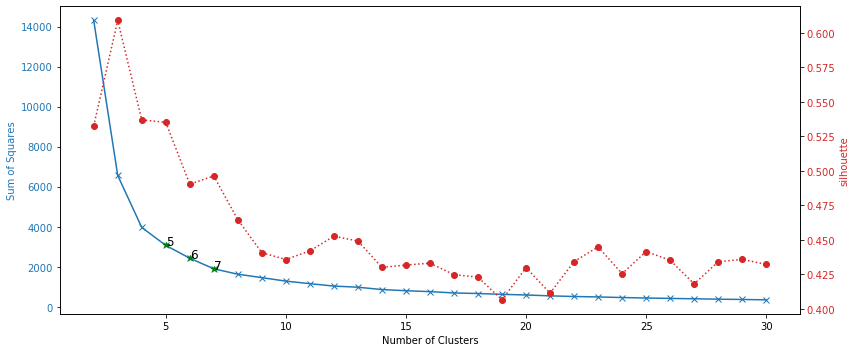

In [42]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Sum of Squares', color=color)
ax1.plot(clusters, distorsions, marker='x', color=color)
for i in idx:
    ax1.plot(clusters[i], distorsions[i], 'g*')
    ax1.text(clusters[i], distorsions[i], clusters[i], fontsize=12)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('silhouette', color=color)  # we already handled the x-label with ax1
ax2.plot(clusters, silhouette, marker='o', linestyle=':', color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 2.2 K-Prototypes
####      Parameters
 -      ----------
 -      **X** : array-like, shape=[n_samples, n_features]
 -      **categorical** : Index of columns that contain categorical data
 -    **n_init** : int, default: 10. 
        Number of time the k-modes algorithm will be run with different
        centroid seeds. 
 -   **n_jobs** : int, default: 1.
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging.

In [9]:
train = model_input.iloc[reservoir]

In [10]:
# Get the index of categorical columns
idx_cat = [train.columns.get_loc(c) for c in categorical_cols if c in df]

In [ ]:
%%time
n_clusters = 10
cost = []
clusters_kp = list(range(2, n_clusters+1))
for i in tqdm(clusters_kp):
    kproto = KPrototypes(n_clusters=i, init='Huang', n_init=5, random_state=np.random.seed(42), n_jobs=-1)
    kproto.fit(train, categorical=idx_cat)
    cost.append(kproto.cost_)

 11%|█████████▎                                                                          | 1/9 [00:06<00:52,  6.56s/it]

#### viz

Text(0.5, 1.0, 'Elbow Curve')

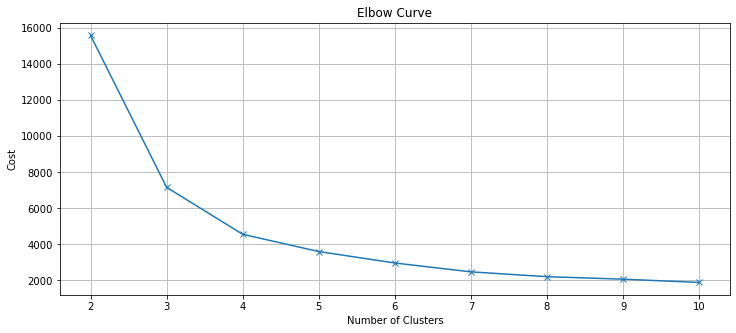

In [15]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(clusters_kp, cost, marker='x')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cost')

ax.grid(True)
plt.title('Elbow Curve')

In [11]:
%%time
#final model
i = int(input("Please enter the number of clusters: "))
kprot_final = KPrototypes(n_clusters=i, init='Huang', n_init=5, random_state=np.random.seed(42), n_jobs=-1)
kprot_final.fit(train, categorical=[len(continuous_cols)])  # train the model

Please enter the number of clusters:4
Wall time: 17.4 s


KPrototypes(cat_dissim=<function matching_dissim at 0x000002E1DF28D0D0>,
            gamma=0.4971132335672968, init='Huang', max_iter=100, n_clusters=4,
            n_init=5, n_jobs=-1,
            num_dissim=<function euclidean_dissim at 0x000002E1DF28D158>,
            random_state=None, verbose=0)

In [20]:
# Output the results
a = kprot_final.predict(model_input, categorical=idx_cat) # make prediction using the whole dataset
df['cluster'] = a